In [21]:
from copy import deepcopy
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn

from collections import defaultdict
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time

from custom_laplace import Subnet, Laplace

In [2]:
lr = 0.001
acquisition_batch_size = 100
train_batch_size = 64
num_train = 100
num_pool = 6000

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply convolutional and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        
        # Apply fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [5]:
def test(model, device, test_loader, epoch=-1):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = float(correct) / len(test_loader.dataset)

    print('Test set for epoch: {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch, 
        test_loss, correct, len(test_loader.dataset),
        100. * accuracy))

    return accuracy

In [6]:
def hasnan(x):
    return torch.isnan(x).any()

def remove_occurrences_from_list(l, items):
    # print(items)
    return list(np.setdiff1d(np.array(l, dtype=int),
        np.array(items, dtype=int), assume_unique=True))

def move_data(indices, from_subset, to_subset):
    from_subset.indices = remove_occurrences_from_list(from_subset.indices, indices)
    if isinstance(to_subset.indices, list):
        to_subset.indices.extend(indices)
    elif isinstance(to_subset.indices, np.ndarray):
        to_subset.indices = np.concatenate([to_subset.indices, np.array(indices)])

In [7]:
def active(model, acquirer, device, data, optimizer):
    train_data, pool_data, test_data = data

    test_accuracies = []
    while len(pool_data) > 0:
        print(f'Acquiring {acquirer.__class__.__name__} batch. Pool size: {len(pool_data)}')
        # get the indices of the best batch of data
        batch_indices = acquirer.select_batch(model, pool_data)
        # move that data from the pool to the training set
        move_data(batch_indices, pool_data, train_data)
        # train on it
        train_loader = torch.utils.data.DataLoader(train_data,
            batch_size=train_batch_size, pin_memory=True, shuffle=True)
        train(model, device, train_loader, optimizer, 0)

        # test the accuracy
        test_loader = torch.utils.data.DataLoader(test_data,
            batch_size=train_batch_size, pin_memory=True, shuffle=True)
        test_accuracies.append(test(model, device, test_loader))

    return test_accuracies

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [9]:
dataset = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [10]:
num_classes = len(dataset.classes)
samples_per_class = (num_train) // num_classes

class_indices = defaultdict(list)

for idx, (_, target) in enumerate(dataset):
    class_indices[target].append(idx)

for indices in class_indices.values():
    np.random.shuffle(indices)

train_indices = []

for _ in range(samples_per_class):
    for indices in class_indices.values():
        train_indices.append(indices.pop())

np.random.shuffle(train_indices)

In [11]:
all_indices = np.arange(len(dataset))
remaining_indices = np.setdiff1d(all_indices, train_indices)
pool_indices = np.random.choice(remaining_indices, size=num_pool, replace=False)

In [12]:
common_elements = np.intersect1d(train_indices, pool_indices)
num_common_elements = len(common_elements)
print(f"Number of common elements: {num_common_elements}")

Number of common elements: 0


In [13]:
train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
pretrain_loader = torch.utils.data.DataLoader(train_data,
    batch_size=train_batch_size, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=train_batch_size, pin_memory=True, shuffle=True)

Files already downloaded and verified


In [23]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
subnet = Subnet(model)

In [15]:
last_two_accuracies = [0, 0]  
epochs = 20
for epoch in range(epochs):
    train(model, device, pretrain_loader, optimizer, epoch)
    accuracy_1 = test(model, device, test_loader, epoch)
    subnet.update_model_variances(epoch, epochs)

Test set for epoch: 0: Average loss: 2.3027, Accuracy: 985/10000 (10%)
Test set for epoch: 1: Average loss: 2.3025, Accuracy: 993/10000 (10%)
Test set for epoch: 2: Average loss: 2.3018, Accuracy: 1001/10000 (10%)
Test set for epoch: 3: Average loss: 2.3009, Accuracy: 1000/10000 (10%)
Test set for epoch: 4: Average loss: 2.2999, Accuracy: 1000/10000 (10%)
Test set for epoch: 5: Average loss: 2.2982, Accuracy: 1282/10000 (13%)
Test set for epoch: 6: Average loss: 2.2956, Accuracy: 1233/10000 (12%)
Test set for epoch: 7: Average loss: 2.2919, Accuracy: 1056/10000 (11%)
Test set for epoch: 8: Average loss: 2.2875, Accuracy: 1122/10000 (11%)
Test set for epoch: 9: Average loss: 2.2796, Accuracy: 1131/10000 (11%)
Test set for epoch: 10: Average loss: 2.2689, Accuracy: 1228/10000 (12%)
Test set for epoch: 11: Average loss: 2.2626, Accuracy: 1272/10000 (13%)
Test set for epoch: 12: Average loss: 2.2427, Accuracy: 1521/10000 (15%)
Test set for epoch: 13: Average loss: 2.2291, Accuracy: 1643/10

In [16]:
train_data = torch.utils.data.Subset(dataset, train_indices)
pool_data = torch.utils.data.Subset(dataset, pool_indices)

In [17]:
processing_batch_size = 200

In [20]:
def H(x, eps=1e-6):
    return -(x+eps)*torch.log(x+eps)

In [21]:
def mc_score(model, x, k=100):
    # I(y;W | x) = H1 - H2 = H(y|x) - E_w[H(y|x,W)]

    with torch.no_grad():
        # take k monte-carlo samples of forward pass w/ dropout
        Y = torch.stack([model(x) for i in range(k)], dim=1)
        H1 = H(Y.mean(axis=1)).sum(axis=1)
        H2 = H(Y).sum(axis=(1,2))/k

        return H1 - H2

In [ ]:
laplace = Laplace(model, device, subnet)
laplace.calculate_ggn(pretrain_loader, F.cross_entropy)

In [22]:
def select_batch(model, pool_data):
    pool_loader = torch.utils.data.DataLoader(pool_data,
                                              batch_size=processing_batch_size, pin_memory=True, shuffle=False)
    scores = torch.zeros(len(pool_data)).to(device)
    for batch_idx, (data, _) in enumerate(pool_loader):
        end_idx = batch_idx + data.shape[0]
        scores[batch_idx:end_idx] = mc_score(model, data.to(device))

    best_local_indices = torch.argsort(scores)[-acquisition_batch_size:]
    best_global_indices = np.array(pool_data.indices)[best_local_indices.cpu().numpy()]
    return best_global_indices

In [27]:
test_accuracies = []
test_accuracies.append(accuracy_1)
acq_num = 1
while len(pool_data) > 0:
    if(acq_num == 20):
        break
    print(f'Acquiring BALD batch. Acq_num: {acq_num} Pool size: {len(pool_data)}')
    # get the indices of the best batch of data
    start_time = time.time()
    batch_indices = select_batch(model, pool_data)
    end_time = time.time()
    print(f"Time taken for acquisition score computation: {end_time - start_time}")
    # move that data from the pool to the training set
    move_data(batch_indices, pool_data, train_data)
    # train on it
    train_loader = torch.utils.data.DataLoader(train_data,
        batch_size=train_batch_size, pin_memory=True, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,
        batch_size=train_batch_size, pin_memory=True, shuffle=True)

    epochs = 20
    for epoch in range(epochs):
        train(model, device, pretrain_loader, optimizer, epoch)
        acc_test = test(model, device, test_loader, epoch)
        subnet.update_model_variances(epoch, epochs)
    laplace.calculate_ggn(train_loader, F.cross_entropy)
    print("\n")
    # test the accuracy
    test_accuracies.append(test(model, device, test_loader))
    if(acc_test >= 0.6):
        break
        
    acq_num = acq_num + 1

Acquiring BALD batch. Acq_num: 1 Pool size: 6000
Time taken for acquisition score computation: 10.48826551437378
Test set for epoch: 1: Average loss: 2.1096, Accuracy: 2283/10000 (23%)
Test set for epoch: 2: Average loss: 2.1836, Accuracy: 2121/10000 (21%)
Test set for epoch: 3: Average loss: 2.1473, Accuracy: 1813/10000 (18%)
Test set for epoch: 4: Average loss: 2.1499, Accuracy: 2206/10000 (22%)
Test set for epoch: 5: Average loss: 2.0712, Accuracy: 2265/10000 (23%)
Test set for epoch: 6: Average loss: 2.0672, Accuracy: 2286/10000 (23%)
Test set for epoch: 7: Average loss: 2.0817, Accuracy: 2203/10000 (22%)
Test set for epoch: 8: Average loss: 2.0617, Accuracy: 2337/10000 (23%)
Test set for epoch: 9: Average loss: 2.0818, Accuracy: 2236/10000 (22%)
Test set for epoch: 10: Average loss: 2.0568, Accuracy: 2425/10000 (24%)
Test set for epoch: 11: Average loss: 2.0599, Accuracy: 2694/10000 (27%)
Test set for epoch: 12: Average loss: 2.0198, Accuracy: 2679/10000 (27%)
Test set for epoch: 

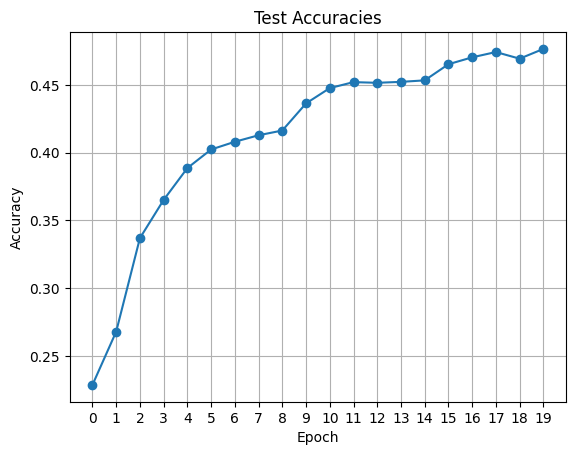

In [28]:
epochs = range(0, len(test_accuracies))

plt.plot(epochs, test_accuracies, marker='o')
plt.title('Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.show()

In [24]:
class A:
    a = 13
    b = 1

class B:
    def __init__(self, a:A) -> None:
        self.a = a
    def changeA(self):
        self.a.a += 1

In [25]:
a = A()

In [26]:
b = B(a)
b.changeA()

In [29]:
a.a

14